# Proyecto de Reconocimiento de Ecuaciones Manuscritas con IA

## Introducción
Este notebook implementa un sistema para reconocer y evaluar ecuaciones matemáticas escritas a mano a partir de imágenes, utilizando un Perceptrón Multicapa (MLP) con PyTorch.

In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import time # Para medir el tiempo de las épocas
import matplotlib.pyplot as plt # Para mostrar la imagen de prueba
import re # Para validación de expresiones antes de eval

# =============================================================================
# 1. Carga y Preprocesamiento de Imágenes (Función del usuario)
# =============================================================================

### Descripción:
Esta sección define la función `load_images` encargada de tomar imágenes individuales de caracteres, aplicar preprocesamiento (escala de grises, inversión, umbralización, detección de contornos, recorte, redimensionamiento a 28x28 y aplanamiento) para prepararlas como entrada al modelo.


In [2]:
def load_images(folder):
    """
    Carga imágenes desde una carpeta, las preprocesa y las aplana.

    Args:
        folder (str): Ruta a la carpeta que contiene las imágenes.

    Returns:
        list: Lista de imágenes preprocesadas y aplanadas (vectores de 784).
              Devuelve una lista vacía si hay errores o no hay imágenes.
    """
    train_data = []
    print(f"Procesando carpeta: {folder}") # Mensaje de depuración
    if not os.path.isdir(folder):
        print(f"Error: La carpeta no existe: {folder}")
        return train_data

    filenames = os.listdir(folder)
    if not filenames:
        print(f"Advertencia: La carpeta está vacía: {folder}")
        return train_data

    for filename in filenames:
        # Ignorar archivos ocultos o especiales
        if filename.startswith('.') or filename == "_directory":
             continue

        file_path = os.path.join(folder, filename)
        try:
            # Leer en escala de grises
            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

            if image is None:
                print(f"Advertencia: No se pudo leer la imagen {filename}. Saltando.")
                continue

            # Invertir imagen (fondo blanco, trazo negro -> fondo negro, trazo blanco)
            image = ~image

            # Umbralizar para binarizar la imagen
            ret, thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

            # Encontrar contornos
            contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

            if not contours:
                print(f"Advertencia: No se encontraron contornos en {filename}. Saltando.")
                continue

            # Encontrar el contorno con el bounding box más grande
            max_area = 0
            best_rect = None # (x, y, w, h)
            for c in contours:
                x, y, w, h = cv2.boundingRect(c)
                area = w * h
                if area > max_area:
                    max_area = area
                    best_rect = (x, y, w, h)

            if best_rect is None:
                 print(f"Advertencia: No se encontró un contorno válido en {filename} después del filtrado inicial. Saltando.")
                 continue

            x_max, y_max, w_max, h_max = best_rect

            # Recortar usando el bounding box del contorno más grande
            padding = 5 # Pequeño padding
            y1 = max(0, y_max - padding)
            y2 = min(thresh.shape[0], y_max + h_max + padding)
            x1 = max(0, x_max - padding)
            x2 = min(thresh.shape[1], x_max + w_max + padding)
            im_crop = thresh[y1:y2, x1:x2]

            if im_crop.size == 0:
                print(f"Advertencia: El recorte resultó vacío para {filename}. Saltando.")
                continue

            # Redimensionar a 28x28
            im_resize = cv2.resize(im_crop, (28, 28), interpolation=cv2.INTER_AREA)

            # Aplanar a 784x1 y añadir a la lista
            im_flattened = im_resize.reshape(784) # Aplanar a (784,)
            train_data.append(im_flattened)

        except Exception as e:
            print(f"Error procesando el archivo {filename}: {e}")

    print(f"Carpeta {os.path.basename(folder)}: {len(train_data)} imágenes cargadas.")
    return train_data

# =============================================================================
# 2. Construcción del Conjunto de Datos Completo
# =============================================================================

### Descripción:
Aquí se define la ruta base del dataset y se itera sobre las carpetas de cada clase (dígitos y operadores). Se utiliza la función `load_images` para cargar todas las imágenes, se les asignan etiquetas numéricas (`label_map`) y se consolida todo en `all_data_list`. Finalmente, se convierten a arrays de NumPy. Se define también `idx_to_char` para la interpretación de las predicciones.


In [3]:
try:
    p = 'Data/Numbers/dataset/' 
    if not os.path.isdir(p):
        raise FileNotFoundError(f"La ruta base del dataset '{p}' no existe. Por favor, corrígela.")
except NameError:
    print("Error: La variable 'p' (ruta base del dataset) no está definida.")
    exit()
except FileNotFoundError as e:
    print(e)
    exit()


all_data_list = []

# Mapeo de nombres de carpeta a etiquetas enteras (DEBE SER CONSISTENTE)
label_map = {
    **{str(i): i for i in range(10)}, # Dígitos 0-9
    'add': 10, # +
    'sub': 11, # -
    'mul': 12, # * (asumiendo que 'mul' es para multiplicación)
    'div': 13, # / (asumiendo que 'div' es para división)
    'eq': 14,  # =
    'dec': 15, # .
    'x': 16, # Si usas x, y, z como en tu código original
    'y': 17,
    'z': 18,
}
# Ajusta NUM_CLASSES según tu mapeo final
NUM_CLASSES = 19

# Mapeo inverso para interpretar predicciones
# Definido aquí para asegurar que esté disponible globalmente
idx_to_char = {v: k for k, v in label_map.items()}
# Ajustar mapeo inverso para símbolos matemáticos comunes si es necesario
idx_to_char[10] = '+'
idx_to_char[11] = '-'
idx_to_char[12] = '*' # Cambiado de 'mul'
idx_to_char[13] = '/' # Cambiado de 'div'
idx_to_char[14] = '='
idx_to_char[15] = '.'
# idx_to_char[16] = '(' # Ya está correcto
# idx_to_char[17] = ')' # Ya está correcto
# idx_to_char[18] = 'z' # Ejemplo si tuvieras 19 clases


print("Iniciando carga de datos...")
for folder_name, label in label_map.items():
    folder_path = os.path.join(p, folder_name)
    images_in_folder = load_images(folder_path)
    for img_flat in images_in_folder:
        all_data_list.append((img_flat, label))

if not all_data_list:
    print("Error: No se cargaron datos. Verifica la ruta 'p' y el contenido de las carpetas.")
    exit()

print(f"\nCarga completa. Total de muestras: {len(all_data_list)}")

features_np_flat = np.array([item[0] for item in all_data_list], dtype=np.float32)
labels_np_int = np.array([item[1] for item in all_data_list], dtype=np.int64)

print(f"Shape de Features (aplanado): {features_np_flat.shape}")
print(f"Shape de Labels (entero): {labels_np_int.shape}")

Iniciando carga de datos...
Procesando carpeta: Data/Numbers/dataset/0
Carpeta 0: 595 imágenes cargadas.
Procesando carpeta: Data/Numbers/dataset/1
Carpeta 1: 562 imágenes cargadas.
Procesando carpeta: Data/Numbers/dataset/2
Carpeta 2: 433 imágenes cargadas.
Procesando carpeta: Data/Numbers/dataset/3
Carpeta 3: 541 imágenes cargadas.
Procesando carpeta: Data/Numbers/dataset/4
Carpeta 4: 526 imágenes cargadas.
Procesando carpeta: Data/Numbers/dataset/5
Carpeta 5: 433 imágenes cargadas.
Procesando carpeta: Data/Numbers/dataset/6
Carpeta 6: 581 imágenes cargadas.
Procesando carpeta: Data/Numbers/dataset/7
Carpeta 7: 533 imágenes cargadas.
Procesando carpeta: Data/Numbers/dataset/8
Carpeta 8: 554 imágenes cargadas.
Procesando carpeta: Data/Numbers/dataset/9
Carpeta 9: 546 imágenes cargadas.
Procesando carpeta: Data/Numbers/dataset/add
Carpeta add: 596 imágenes cargadas.
Procesando carpeta: Data/Numbers/dataset/sub
Carpeta sub: 655 imágenes cargadas.
Procesando carpeta: Data/Numbers/dataset

# =============================================================================
# 3. Cálculo de Mean/Std y Normalización (Variables Globales)
# =============================================================================

### Descripción:
 Se calculan la media y la desviación estándar de los píxeles de todas las imágenes del conjunto de datos. Estos valores son cruciales para la normalización Z-score que se aplicará a los datos antes de entrenar el modelo y al preprocesar nuevas imágenes para predicción. Las imágenes se normalizan inicialmente a una escala de [0,1].


In [4]:
# Estas variables (mean, std) son necesarias para preprocesar nuevas imágenes
mean_pixel = np.mean(features_np_flat)
std_pixel = np.std(features_np_flat)
features_normalized_01 = features_np_flat / 255.0
mean = np.mean(features_normalized_01) # Media global [0,1]
std = np.std(features_normalized_01)   # Std global [0,1]
if std < 1e-6: std = 1.0

print(f"\nEstadísticas calculadas (usadas para normalización):")
print(f"  Mean (0-1 scale): {mean:.4f}")
print(f"  Std Dev (0-1 scale): {std:.4f}")


Estadísticas calculadas (usadas para normalización):
  Mean (0-1 scale): 0.2147
  Std Dev (0-1 scale): 0.3798


# =============================================================================
# 4. Preparación para PyTorch (Tensores, Dataset, DataLoader)
# =============================================================================

### Descripción:
Los arrays de NumPy (características y etiquetas) se convierten a tensores de PyTorch. Las características se normalizan utilizando la media y desviación estándar calculadas previamente. Se crea un `TensorDataset` y se divide en conjuntos de entrenamiento y validación. Finalmente, se preparan los `DataLoader` para iterar sobre los datos en batches durante el entrenamiento y la evaluación.


In [5]:
features_tensor = torch.tensor(features_np_flat, dtype=torch.float32)
labels_tensor = torch.tensor(labels_np_int, dtype=torch.long)

features_tensor = (features_tensor / 255.0 - mean) / std

print(f"\nShapes de Tensores:")
print(f"  Features Tensor: {features_tensor.shape}")
print(f"  Labels Tensor: {labels_tensor.shape}")

full_dataset = TensorDataset(features_tensor, labels_tensor)

# División Train/Valid
train_size = int(0.8 * len(full_dataset))
valid_size = len(full_dataset) - train_size
valid_dataset = None
if train_size > 0 and valid_size > 0:
    train_dataset, valid_dataset = random_split(full_dataset, [train_size, valid_size])
    print(f'\nDivisión del Dataset:')
    print(f'  Num Train: {len(train_dataset)}')
    print(f'  Num Valid: {len(valid_dataset)}')
elif len(full_dataset) > 0:
     print('\nDataset demasiado pequeño para dividir. Usando todo para entrenamiento.')
     train_dataset = full_dataset
else:
    print("Error: Dataset vacío después de cargar datos.")
    exit()


# DataLoaders
BATCH_SIZE = 64
train_iterator = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
valid_iterator = DataLoader(valid_dataset, batch_size=BATCH_SIZE) if valid_dataset else None

print(f"DataLoaders creados con Batch Size: {BATCH_SIZE}")
if not valid_iterator: print("Advertencia: No se creó DataLoader de validación.")


Shapes de Tensores:
  Features Tensor: torch.Size([10071, 784])
  Labels Tensor: torch.Size([10071])

División del Dataset:
  Num Train: 8056
  Num Valid: 2015
DataLoaders creados con Batch Size: 64


# =============================================================================
# 5. Definición del Modelo MLP (Adaptado)
# =============================================================================

### Descripción:
Se define la arquitectura de la red neuronal (MLP). Consiste en una capa de entrada, una capa oculta con activación ReLU, y una capa de salida para la clasificación de los caracteres. Se calcula e imprime el número total de parámetros entrenables del modelo.


In [6]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):
        h_1 = F.relu(self.input_fc(x))
        h_2 = F.relu(self.hidden_fc(h_1))
        y_pred = self.output_fc(h_2)
        return y_pred

INPUT_DIM = 28 * 28
OUTPUT_DIM = NUM_CLASSES
model = MLP(INPUT_DIM, OUTPUT_DIM)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nEl modelo MLP tiene {count_parameters(model):,} parámetros entrenables.')


El modelo MLP tiene 223,269 parámetros entrenables.


# =============================================================================
# 6. Configuración del Entrenamiento (Optimizador, Pérdida, Dispositivo)
# =============================================================================

### Descripción:
Se configura el proceso de entrenamiento: se elige el optimizador (Adam), la función de pérdida (CrossEntropyLoss, adecuada para clasificación multiclase) y se determina el dispositivo de cómputo (CPU o GPU si está disponible). El modelo y la función de pérdida se mueven al dispositivo seleccionado.


In [7]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)
print(f"Entrenamiento configurado en dispositivo: {device}")

Entrenamiento configurado en dispositivo: cpu


# =============================================================================
# 7. Funciones Auxiliares de Entrenamiento y Evaluación (del Notebook)
# =============================================================================

### Descripción:
 Se definen funciones clave para el ciclo de entrenamiento:
 - `calculate_accuracy`: Calcula la precisión de las predicciones.
 - `train`: Realiza una época de entrenamiento sobre el conjunto de datos, actualizando los pesos del modelo.
 - `evaluate`: Evalúa el rendimiento del modelo sobre un conjunto de datos (generalmente validación o prueba) sin actualizar los pesos.
 - `epoch_time`: Calcula el tiempo transcurrido por época.


In [8]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    len_iterator = len(iterator)
    if len_iterator == 0: return 0.0, 0.0
    for (x, y) in iterator:
        x = x.to(device); y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item(); epoch_acc += acc.item()
    return epoch_loss / len_iterator, epoch_acc / len_iterator

def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    if iterator is None: return 0.0, 0.0
    len_iterator = len(iterator)
    if len_iterator == 0: return 0.0, 0.0
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device); y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item(); epoch_acc += acc.item()
    return epoch_loss / len_iterator, epoch_acc / len_iterator

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# =============================================================================
# 8. Bucle Principal de Entrenamiento
# =============================================================================

### Descripción:
Este es el bucle donde se entrena el modelo durante un número definido de épocas (`EPOCHS`). En cada época, se entrena el modelo y se evalúa en el conjunto de validación. Se guarda el modelo que obtenga la menor pérdida de validación (`best_valid_loss`) en el archivo `mlp_custom_data_model1.pt`. Se imprime el progreso (pérdida y precisión) por época.


In [9]:
EPOCHS = 15 # Reducido para pruebas rápidas, ajustar según sea necesario
best_valid_loss = float('inf')
model_save_path = 'mlp_custom_data_model1.pt'
# --- Omitir entrenamiento si el modelo ya existe ---
if os.path.exists(model_save_path):
    print(f"\nEl archivo del modelo '{model_save_path}' ya existe. Saltando entrenamiento.")
else:
    print("\nIniciando entrenamiento...")
    for epoch in range(EPOCHS):
        start_time = time.time()
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
        valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device) if valid_iterator else (0.0, 0.0)
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        save_model = False
        if valid_iterator:
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                save_model = True
        elif epoch == EPOCHS - 1:
             print("\nAdvertencia: No hay datos de validación. Guardando el modelo de la última época.")
             save_model = True
        if save_model:
            torch.save(model.state_dict(), model_save_path)
            if valid_iterator: print(f"\tMejor modelo (valid loss) guardado en {model_save_path}")
            else: print(f"\tÚltimo modelo guardado en {model_save_path}")
        print(f'Epoch: {epoch+1:02}/{EPOCHS} | Tiempo: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        if valid_iterator: print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        else: print('\t (Sin datos de validación para evaluar)')
    # Asegurarse de que el modelo se guarde si no hubo validación
    if not os.path.exists(model_save_path) and not valid_iterator and EPOCHS > 0:
         torch.save(model.state_dict(), model_save_path)
         print(f"\nModelo final guardado en {model_save_path} (sin validación).")
    print("\nEntrenamiento finalizado.")

if os.path.exists(model_save_path): print(f"El modelo se guardó en: {model_save_path}")
else: print("Advertencia: No se guardó ningún modelo.")


El archivo del modelo 'mlp_custom_data_model1.pt' ya existe. Saltando entrenamiento.
El modelo se guardó en: mlp_custom_data_model1.pt


# =============================================================================
# 9. Cargar el mejor modelo y evaluar en el conjunto de validación
# =============================================================================

### Descripción:
 Después del entrenamiento (o si se omite porque el modelo ya existe), esta sección carga los pesos del mejor modelo guardado (`mlp_custom_data_model1.pt`) en una nueva instancia de la arquitectura MLP. Luego, se evalúa este modelo cargado en el conjunto de validación para verificar su rendimiento final.


In [10]:
print(f"\nIntentando cargar y evaluar el modelo desde: {model_save_path}")
loaded_model = None # Inicializar
if os.path.exists(model_save_path):
    # Crear una instancia de la MISMA arquitectura
    loaded_model = MLP(INPUT_DIM, OUTPUT_DIM)
    try:
        # Cargar los pesos guardados (state_dict)
        loaded_model.load_state_dict(torch.load(model_save_path, map_location=device))
        print(f"State dict cargado correctamente desde {model_save_path}")
        loaded_model = loaded_model.to(device) # Mover al dispositivo
        loaded_model.eval() # Poner en modo evaluación (IMPORTANTE)
        print("Modelo cargado y puesto en modo evaluación (model.eval())")

        # Evaluar en el conjunto de validación (si existe)
        if valid_iterator:
            print("\nEvaluando el modelo cargado en el conjunto de validación...")
            final_valid_loss, final_valid_acc = evaluate(loaded_model, valid_iterator, criterion, device)
            print(f'Resultado de la evaluación:')
            print(f'\tLoss: {final_valid_loss:.3f} | Acc: {final_valid_acc*100:.2f}%')
        else:
            print("No hay conjunto de validación para evaluar el modelo cargado.")
    except Exception as e:
         print(f"Error al cargar el state_dict o evaluar el modelo desde '{model_save_path}': {e}")
         loaded_model = None # Indicar que la carga falló
else:
    print(f"Advertencia: No se encontró el archivo del modelo guardado '{model_save_path}'. No se pudo cargar ni evaluar.")


Intentando cargar y evaluar el modelo desde: mlp_custom_data_model1.pt
State dict cargado correctamente desde mlp_custom_data_model1.pt
Modelo cargado y puesto en modo evaluación (model.eval())

Evaluando el modelo cargado en el conjunto de validación...
Resultado de la evaluación:
	Loss: 0.186 | Acc: 93.50%


# =============================================================================
# 10. Probar el modelo cargado con una imagen (Lógica de Usuario Adaptada)
# =============================================================================

### Descripción:
Se define la función `predict_equation_from_image`. Esta función toma la ruta de una imagen que contiene una ecuación completa, la preprocesa, segmenta los caracteres individuales, filtra contornos anidados o solapados, y utiliza el modelo MLP cargado para predecir cada carácter. Finalmente, reconstruye la cadena de la ecuación y la evalúa matemáticamente. También incluye la visualización de los caracteres segmentados y sus predicciones.


In [11]:
def predict_equation_from_image(image_path, model_to_use, device, target_mean, target_std, idx_to_char_map):
    """
    Procesa una imagen que contiene una secuencia de caracteres, predice cada
    carácter usando el modelo MLP cargado, construye la ecuación y la evalúa.

    Args:
        image_path (str): Ruta a la imagen a procesar.
        model_to_use (torch.nn.Module): El modelo MLP cargado y en modo eval.
        device (torch.device): Dispositivo ('cuda' o 'cpu').
        target_mean (float): Media usada para normalizar ([0,1] scale).
        target_std (float): Desviación estándar usada para normalizar ([0,1] scale).
        idx_to_char_map (dict): Mapeo de índice de clase a carácter.

    Returns:
        str: La ecuación reconocida.
        float or str: El resultado de la evaluación o un mensaje de error.
    """
    # Verificar si el mapeo existe antes de usarlo dentro de la función
    if idx_to_char_map is None:
        print("Error interno: El mapeo idx_to_char_map no fue proporcionado a la función.")
        return "Error Mapeo", "Error"

    try:
        # --- 1. Cargar y Preprocesar Imagen (OpenCV) ---
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Error: No se pudo leer la imagen en {image_path}")
            return "Error de lectura", "Error"

        original_img_for_display = img.copy() # Para visualización

        img = ~img # Invertir
        _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY) # Umbralizar
        ctrs, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # Contornos

        if not ctrs:
            print("No se encontraron contornos en la imagen.")
            return "Sin contornos", "Error"

        # Ordenar contornos por posición x
        cnt = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
        print(f"Contornos encontrados y ordenados: {len(cnt)}")

        # --- 2. Filtrar Contornos Anidados (Lógica del usuario) ---
        rects = [cv2.boundingRect(c) for c in cnt] # Obtener bounding boxes (x, y, w, h)

        bool_rect = []
        for r in rects:
            l = []
            for rec in rects:
                flag = 0
                if rec != r:
                    # Comprobar si hay solapamiento significativo (ajustar el +10 si es necesario)
                    x1_r, y1_r, w_r, h_r = r
                    x2_r, y2_r = x1_r + w_r, y1_r + h_r
                    x1_rec, y1_rec, w_rec, h_rec = rec
                    x2_rec, y2_rec = x1_rec + w_rec, y1_rec + h_rec

                    # Chequear si un rectángulo está *dentro* de otro (más robusto para anidamiento)
                    r_inside_rec = (x1_r >= x1_rec) and (y1_r >= y1_rec) and (x2_r <= x2_rec) and (y2_r <= y2_rec)
                    rec_inside_r = (x1_rec >= x1_r) and (y1_rec >= y1_r) and (x2_rec <= x2_r) and (y2_rec <= y2_r)

                    if r_inside_rec or rec_inside_r:
                         flag = 1
                l.append(flag)
            bool_rect.append(l)

        dump_rect = []
        for i in range(len(cnt)):
            for j in range(len(cnt)):
                if bool_rect[i][j] == 1: # Si hay anidamiento/solapamiento
                    area1 = rects[i][2] * rects[i][3]
                    area2 = rects[j][2] * rects[j][3]
                    # Marcar el rectángulo más pequeño para eliminar
                    if area1 <= area2: # Incluir igualdad para eliminar uno si son idénticos
                        if list(rects[i]) not in dump_rect: dump_rect.append(list(rects[i]))
                    else:
                         if list(rects[j]) not in dump_rect: dump_rect.append(list(rects[j]))


        # Eliminar duplicados de dump_rect (ya se hace en la línea anterior)
        # dump_rect_unique = [list(item) for item in set(tuple(row) for row in dump_rect)] # No es necesario si se añade con if not in
        print(f"Rectángulos marcados para eliminar (anidados/solapados): {len(dump_rect)}")

        # Obtener los rectángulos finales
        final_rect = [r for r in rects if list(r) not in dump_rect]
        print(f"Rectángulos finales después del filtrado: {len(final_rect)}")
        # Ordenar rectángulos finales por 'x' de nuevo, por si acaso
        final_rect.sort(key=lambda r: r[0])

        # --- 3. Procesar y Predecir cada Carácter Final ---
        processed_chars_tensors = [] # Almacenará los tensores listos para el modelo
        processed_chars_imgs = [] # Almacenará imágenes 28x28 para visualización

        for r in final_rect:
            x, y, w, h = r
            # Añadir padding al recortar (con cuidado de no salirse)
            pad = 10
            y1 = max(0, y - pad); y2 = min(thresh.shape[0], y + h + pad)
            x1 = max(0, x - pad); x2 = min(thresh.shape[1], x + w + pad)
            im_crop = thresh[y1:y2, x1:x2]

            if im_crop.size == 0:
                print(f"Advertencia: Recorte vacío para rect {r}. Saltando.")
                continue

            # Redimensionar a 28x28
            im_resize = cv2.resize(im_crop, (28, 28), interpolation=cv2.INTER_AREA)
            processed_chars_imgs.append(im_resize) # Guardar para mostrar

            # Aplanar y asegurar tipo float32
            im_flattened = im_resize.reshape(784).astype(np.float32)

            # Convertir a Tensor
            char_tensor = torch.tensor(im_flattened, dtype=torch.float32)

            # Normalizar (usando mean/std globales)
            # Asegurarse de que std no sea cero
            safe_std = target_std if target_std > 1e-6 else 1.0
            char_tensor = (char_tensor / 255.0 - target_mean) / safe_std

            # Añadir dimensión de batch y mover al dispositivo
            char_tensor = char_tensor.unsqueeze(0).to(device) # Shape: [1, 784]
            processed_chars_tensors.append(char_tensor)

        if not processed_chars_tensors:
            print("No se pudieron procesar caracteres válidos después del filtrado.")
            return "Sin caracteres válidos", "Error"

        # --- 4. Realizar Predicciones y Construir Ecuación ---
        equation = ''
        confidences = []
        predicted_indices = []

        model_to_use.eval() # Asegurarse de que esté en modo evaluación
        with torch.no_grad():
            for char_tensor in processed_chars_tensors:
                prediction_logits = model_to_use(char_tensor)
                probabilities = F.softmax(prediction_logits, dim=1)
                confidence, predicted_idx = torch.max(probabilities, 1)

                predicted_idx_item = predicted_idx.item()
                predicted_indices.append(predicted_idx_item)
                confidences.append(confidence.item())

                # Construir la ecuación usando el mapeo
                char = idx_to_char_map.get(predicted_idx_item, '?') # Usar '?' si el índice no está mapeado
                equation += char
                print(f"  Predicción: Índice={predicted_idx_item}, Carácter='{char}', Confianza={confidence.item()*100:.1f}%")

        print(f"\nEcuación Reconocida: {equation}")

        # --- 5. Evaluar la Ecuación ---
        result = "No evaluable"
        try:
            # Validar un poco la expresión antes de usar eval
            # Permitir números, operadores +, -, *, /, ., (, ) y espacios
            # Mejorar regex para permitir números decimales y negativos al inicio
            # Quitar espacios ANTES de validar con regex y evaluar
            cleaned_equation_for_eval = equation.replace(' ', '')
            if re.fullmatch(r"^[()]*([-+]?([0-9]*\.?[0-9]+|[0-9]+\.?[0-9]*)[()]*[+\-*/]?)+$", cleaned_equation_for_eval):
                 # ¡PRECAUCIÓN! eval() puede ser inseguro. Usar con cuidado.
                 result = eval(cleaned_equation_for_eval)
                 print(f"Resultado de la evaluación: {result}")
            else:
                 # Intentar una limpieza básica (ej. quitar '=') si existe y no es evaluable
                 cleaned_equation_no_equals = cleaned_equation_for_eval.rstrip('=')
                 if cleaned_equation_no_equals != cleaned_equation_for_eval and re.fullmatch(r"^[()]*([-+]?([0-9]*\.?[0-9]+|[0-9]+\.?[0-9]*)[()]*[+\-*/]?)+$", cleaned_equation_no_equals):
                     print(f"Intentando evaluar versión limpiada (sin '=' al final): {cleaned_equation_no_equals}")
                     result = eval(cleaned_equation_no_equals)
                     print(f"Resultado de la evaluación (limpiada): {result}")
                 else:
                     result = "Expresión no válida"
                     print(f"La expresión '{equation}' (limpiada: '{cleaned_equation_for_eval}') no parece válida para evaluar.")


        except ZeroDivisionError:
            result = "Error: División por cero"
            print(result)
        except SyntaxError as e:
            result = f"Error de sintaxis: {e}"
            print(result)
        except Exception as e:
            result = f"Error durante evaluación: {e}"
            print(result)

        # --- 6. Visualización (Opcional) ---
        try:
            num_chars = len(processed_chars_imgs)
            if num_chars > 0:
                 cols = min(num_chars, 8)
                 rows = (num_chars + cols - 1) // cols
                 fig, axs = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 2.5)) # Aumentar altura
                 if rows == 1 and cols == 1: # Caso de un solo subplot
                     axs = np.array([axs])
                 axs = axs.flatten()

                 for i in range(num_chars):
                     axs[i].imshow(processed_chars_imgs[i], cmap='gray')
                     pred_char = idx_to_char_map.get(predicted_indices[i], '?')
                     conf = confidences[i] * 100
                     axs[i].set_title(f"'{pred_char}'\n({conf:.0f}%)") # Título en dos líneas
                     axs[i].axis('off')

                 for j in range(num_chars, len(axs)):
                     axs[j].axis('off')

                 fig.suptitle(f"Predicciones Carácter por Carácter\nEcuación: {equation}\nResultado: {result}", fontsize=12)
                 plt.tight_layout(rect=[0, 0.03, 1, 0.92]) # Ajustar para título más largo
                 plt.show()

        except Exception as e:
            print(f"No se pudo mostrar la visualización de caracteres: {e}")


        return equation, result

    except Exception as e:
        print(f"Error general en predict_equation_from_image: {e}")
        return "Error general", "Error"

In [12]:

def predict_equation_from_image(image_path, model_to_use, device, target_mean, target_std, idx_to_char_map):
    """
    Procesa una imagen que contiene una secuencia de caracteres, predice cada
    carácter usando el modelo MLP cargado, construye la ecuación y la evalúa.
    Si se detecta "==" en la ecuación, se reemplaza por "=".

    Args:
        image_path (str): Ruta a la imagen a procesar.
        model_to_use (torch.nn.Module): El modelo MLP cargado y en modo eval.
        device (torch.device): Dispositivo ('cuda' o 'cpu').
        target_mean (float): Media usada para normalizar ([0,1] scale).
        target_std (float): Desviación estándar usada para normalizar ([0,1] scale).
        idx_to_char_map (dict): Mapeo de índice de clase a carácter.

    Returns:
        str: La ecuación reconocida (con "==" reemplazado por "=").
        float or str: El resultado de la evaluación o un mensaje de error.
    """
    if idx_to_char_map is None:
        print("Error interno: El mapeo idx_to_char_map no fue proporcionado a la función.")
        return "Error Mapeo", "Error"

    try:
        # --- 1. Cargar y Preprocesar Imagen (OpenCV) ---
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Error: No se pudo leer la imagen en {image_path}")
            return "Error de lectura", "Error"

        img_inverted = ~img # Invertir para que el trazo sea blanco y el fondo negro
        _, thresh = cv2.threshold(img_inverted, 127, 255, cv2.THRESH_BINARY) # Umbralizar
        ctrs, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # Contornos

        if not ctrs:
            print("No se encontraron contornos en la imagen.")
            return "Sin contornos", "Error"

        # Ordenar contornos por posición x
        cnt = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
        print(f"Contornos encontrados inicialmente y ordenados: {len(cnt)}")

        # --- 2. Filtrar Contornos Anidados (Lógica del usuario) ---
        rects = [cv2.boundingRect(c) for c in cnt]

        bool_rect = []
        for r_outer in rects:
            l_inner = []
            for rec_inner in rects:
                flag = 0
                if rec_inner != r_outer:
                    x1_r, y1_r, w_r, h_r = r_outer
                    x2_r, y2_r = x1_r + w_r, y1_r + h_r
                    x1_rec, y1_rec, w_rec, h_rec = rec_inner
                    x2_rec, y2_rec = x1_rec + w_rec, y1_rec + h_rec

                    r_inside_rec = (x1_r >= x1_rec) and (y1_r >= y1_rec) and (x2_r <= x2_rec) and (y2_r <= y2_rec)
                    rec_inside_r = (x1_rec >= x1_r) and (y1_rec >= y1_r) and (x2_rec <= x2_r) and (y2_rec <= y2_r)

                    if r_inside_rec or rec_inside_r:
                        flag = 1
                l_inner.append(flag)
            bool_rect.append(l_inner)

        dump_rect = []
        for i in range(len(cnt)):
            for j in range(len(cnt)):
                if bool_rect[i][j] == 1:
                    area1 = rects[i][2] * rects[i][3]
                    area2 = rects[j][2] * rects[j][3]
                    if area1 <= area2:
                        if list(rects[i]) not in dump_rect: dump_rect.append(list(rects[i]))
                    else:
                        if list(rects[j]) not in dump_rect: dump_rect.append(list(rects[j]))
        
        print(f"Rectángulos marcados para eliminar (anidados/solapados): {len(dump_rect)}")
        final_rect_to_process = [r for r in rects if list(r) not in dump_rect]
        final_rect_to_process.sort(key=lambda r: r[0]) # Asegurar orden por x
        print(f"Rectángulos finales después del filtrado: {len(final_rect_to_process)}")

        # --- 3. Procesar y Predecir cada Carácter Final ---
        processed_chars_tensors = []
        processed_chars_imgs = []

        for r_idx, r_val in enumerate(final_rect_to_process):
            x, y, w, h = r_val
            
            if w == 0 or h == 0: 
                print(f"Advertencia: Rectángulo con dimensión cero {r_val}. Saltando.")
                continue

            pad = 15 # Padding
            y1_crop = max(0, y - pad); y2_crop = min(thresh.shape[0], y + h + pad)
            x1_crop = max(0, x - pad); x2_crop = min(thresh.shape[1], x + w + pad)
            im_crop = thresh[y1_crop:y2_crop, x1_crop:x2_crop]

            if im_crop.size == 0:
                print(f"Advertencia: Recorte vacío para rect {r_val}. Saltando.")
                continue

            im_resize = cv2.resize(im_crop, (28, 28), interpolation=cv2.INTER_AREA)
            processed_chars_imgs.append(im_resize)

            im_flattened = im_resize.reshape(784).astype(np.float32)
            char_tensor = torch.tensor(im_flattened, dtype=torch.float32)

            safe_std = target_std if target_std > 1e-6 else 1.0
            char_tensor = (char_tensor / 255.0 - target_mean) / safe_std
            char_tensor = char_tensor.unsqueeze(0).to(device)
            processed_chars_tensors.append(char_tensor)

        if not processed_chars_tensors:
            print("No se pudieron procesar caracteres válidos después del filtrado.")
            return "Sin caracteres válidos", "Error"

        # --- 4. Realizar Predicciones y Construir Ecuación ---
        raw_equation = '' # Ecuación antes del post-procesamiento
        confidences = []
        predicted_indices = []

        model_to_use.eval()
        with torch.no_grad():
            for char_tensor in processed_chars_tensors:
                prediction_logits = model_to_use(char_tensor)
                probabilities = F.softmax(prediction_logits, dim=1)
                confidence, predicted_idx = torch.max(probabilities, 1)

                predicted_idx_item = predicted_idx.item()
                predicted_indices.append(predicted_idx_item)
                confidences.append(confidence.item())

                char = idx_to_char_map.get(predicted_idx_item, '?')
                raw_equation += char # Construir la ecuación cruda
                print(f"  Predicción: Índice={predicted_idx_item}, Carácter='{char}', Confianza={confidence.item()*100:.1f}%")

        print(f"\nEcuación Cruda Reconocida: {raw_equation}")

        # --- NUEVO: Post-procesamiento para reemplazar "==" por "=" ---
        equation = raw_equation.replace("==", "=")
        if "==" in raw_equation:
            print(f"Ecuación Corregida (reemplazando '==' por '='): {equation}")
        else:
            print(f"Ecuación Final (sin cambios de '=='): {equation}")


        # --- 5. Evaluar la Ecuación ---
        result = "No evaluable"
        try:
            cleaned_equation_for_eval = equation.replace(' ', '')
            
            if re.fullmatch(r"^[()]*([-+]?([0-9]*\.?[0-9]+|[0-9]+\.?[0-9]*)[()]*[+\-*/]?)+$", cleaned_equation_for_eval):
                result = eval(cleaned_equation_for_eval)
                print(f"Resultado de la evaluación (expresión directa): {result}")
            elif cleaned_equation_for_eval.endswith('=') and \
                 re.fullmatch(r"^[()]*([-+]?([0-9]*\.?[0-9]+|[0-9]+\.?[0-9]*)[()]*[+\-*/]?)+$", cleaned_equation_for_eval[:-1]):
                expression_to_eval = cleaned_equation_for_eval[:-1]
                print(f"Intentando evaluar versión limpiada (sin '=' al final): {expression_to_eval}")
                result = eval(expression_to_eval)
                print(f"Resultado de la evaluación (limpiada): {result}")
            else:
                result = "Expresión no válida para eval()"
                print(f"La expresión '{equation}' (limpiada: '{cleaned_equation_for_eval}') no parece válida para evaluar con las reglas actuales.")

        except ZeroDivisionError:
            result = "Error: División por cero"
            print(result)
        except SyntaxError as e:
            result = f"Error de sintaxis en eval(): {e}"
            print(result)
        except Exception as e:
            result = f"Error durante evaluación con eval(): {e}"
            print(result)

        # --- 6. Visualización (Opcional) ---
        # La visualización mostrará los caracteres tal como se enviaron al modelo (antes del reemplazo de "==")
        try:
            num_chars_to_display = len(processed_chars_imgs)
            if num_chars_to_display > 0:
                cols = min(num_chars_to_display, 8)
                rows = (num_chars_to_display + cols - 1) // cols
                fig, axs = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 2.5))
                if rows == 1 and cols == 1:
                    axs = np.array([axs]) 
                axs = axs.flatten()

                for i in range(num_chars_to_display):
                    axs[i].imshow(processed_chars_imgs[i], cmap='gray')
                    # Mostrar el carácter predicho originalmente por el modelo para esta imagen
                    original_pred_char_display = idx_to_char_map.get(predicted_indices[i], '?')
                    conf_display = confidences[i] * 100
                    axs[i].set_title(f"'{original_pred_char_display}'\n({conf_display:.0f}%)")
                    axs[i].axis('off')

                for j in range(num_chars_to_display, len(axs)):
                    axs[j].axis('off')

                # El título de la figura mostrará la ecuación final (posiblemente corregida)
                fig.suptitle(f"Predicciones (Pre-corrección '==')\nEcuación Final: {equation}\nResultado: {result}", fontsize=12)
                plt.tight_layout(rect=[0, 0.03, 1, 0.92])
                plt.show()
        except Exception as e:
            print(f"No se pudo mostrar la visualización de caracteres: {e}")

        return equation, result # Devuelve la ecuación posiblemente corregida

    except Exception as e:
        print(f"Error general en predict_equation_from_image: {e}")
        return "Error general", "Error"



# =============================================================================
# 11. Prueba de funcionamiento
# =============================================================================

### Descripción:
Esta sección ejecuta una prueba utilizando la función `predict_equation_from_image` con una imagen de ejemplo (especificada en `test_equation_image_path`). Muestra la ecuación reconocida, el resultado de su evaluación y la visualización de los caracteres procesados. Es el punto final para probar la funcionalidad completa del sistema.



--- Probando con una imagen que contiene una ecuación ---
Contornos encontrados inicialmente y ordenados: 3
Rectángulos marcados para eliminar (anidados/solapados): 0
Rectángulos finales después del filtrado: 3
  Predicción: Índice=5, Carácter='5', Confianza=99.3%
  Predicción: Índice=15, Carácter='.', Confianza=98.6%
  Predicción: Índice=7, Carácter='7', Confianza=99.5%

Ecuación Cruda Reconocida: 5.7
Ecuación Final (sin cambios de '=='): 5.7
Resultado de la evaluación (expresión directa): 5.7


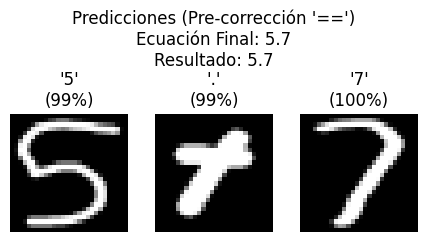


--- Resumen Final ---
Imagen Procesada: C:/Users/Wisp8/Desktop/Numeros/Ec2.png
Ecuación Reconocida: 5.7
Resultado Evaluación: 5.7


In [22]:
# --- Ejecución de la prueba con una imagen ---
if loaded_model is not None: # Solo si el modelo se cargó correctamente
    if 'idx_to_char' in globals():
        print("\n--- Probando con una imagen que contiene una ecuación ---")

        # !!! IMPORTANTE: Cambia esta ruta a la de tu imagen !!!
        test_equation_image_path = "C:/Users/Wisp8/Desktop/Numeros/Ec2.png" 

        if not os.path.exists(test_equation_image_path):
            print(f"Error: La imagen de prueba no existe en: {test_equation_image_path}")
            print("Por favor, crea una imagen (ej. 'Data/Prueba.png') con una ecuación simple (ej. 12+5) o cambia la ruta.")
        else:
            # Llamar a la nueva función de predicción
            recognized_equation, evaluation_result = predict_equation_from_image(
                test_equation_image_path,
                loaded_model,
                device,
                mean, # Media global calculada en sección 3
                std,  # Std global calculada en sección 3
                idx_to_char 
            )

            print(f"\n--- Resumen Final ---")
            print(f"Imagen Procesada: {test_equation_image_path}")
            print(f"Ecuación Reconocida: {recognized_equation}")
            print(f"Resultado Evaluación: {evaluation_result}")
    else:
        # Mensaje de error si idx_to_char no está definido
        print("\nError Crítico: La variable 'idx_to_char' no está definida en el scope global.")
        print("Asegúrate de que la Sección 2 (donde se define idx_to_char) se haya ejecutado correctamente antes de esta sección.")

else:
    print("\nNo se puede probar con una imagen porque el modelo no se cargó correctamente.")